In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [71]:
df1 = pd.read_csv('inputprice.csv')
df2 = pd.read_csv('Linear Low Density Polyethylene Futures Historical Data.csv')
df2

,Date,Price,Open,High,Low,Vol.,Change %
0,14-Aug-22,7669.0,7840.0,7987.0,7592.0,134.07K,-0.05
1,7-Aug-22,8098.0,7808.0,7808.0,7808.0,0.06K,0.04
2,31-Jul-22,7784.0,8666.0,8666.0,8010.0,0.16K,-0.03
3,24-Jul-22,8064.0,7673.0,8212.0,7673.0,4.14K,0.05
4,17-Jul-22,7673.0,7655.0,8009.0,7540.0,1.41K,-0.01
...,...,...,...,...,...,...,...
540,5-Feb-12,9710.0,9745.0,9835.0,9710.0,0.33K,0.00
541,29-Jan-12,9755.0,9680.0,9845.0,9680.0,0.48K,0.02
542,15-Jan-12,9540.0,9190.0,9675.0,9100.0,3.44K,0.03
543,8-Jan-12,9235.0,9250.0,9365.0,9205.0,5.01K,0.00


In [72]:
df['HDPE/brick'] = df['HDPE price per kg'] * 0.1111
df['Sand/brick'] = df['Sand price per kg'] * 0.4444

hdpe_mean = df['HDPE/brick'].mean()
sand_mean = df['Sand/brick'].mean()

In [75]:
price_change = np.log(1+df2['Price'].pct_change())

In [76]:
price_change

0           NaN
1      0.054431
2     -0.039547
3      0.035339
4     -0.049702
         ...   
540    0.001030
541    0.004624
542   -0.022286
543   -0.032493
544    0.000000
Name: Price, Length: 545, dtype: float64

In [77]:
mu, sigma = price_change.mean(), price_change.std()

In [88]:
sim_price = np.random.normal(mu, sigma, 260)

In [84]:
brickprice = 10
initial = brickprice - hdpe_mean - sand_mean

In [138]:
net = initial * ((hdpe_mean/initial)*(sim_price + 1).cumprod())

In [139]:
num_simulations = 1000
end_profit = []

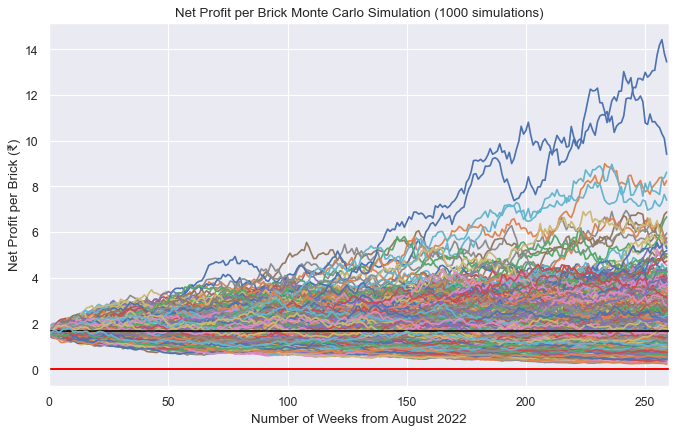

In [157]:
plt.figure(figsize=(10, 6), dpi=80)

for i in range(num_simulations):
    sim_price = np.random.normal(mu, sigma, 260)
    net = initial * (sim_price + 1).cumprod()
    end_profit.append(net[-1])
    plt.axhline(initial, c='k')
    plt.axhline(0, c='red')
    plt.title("Net Profit per Brick Monte Carlo Simulation (" + str(num_simulations) + " simulations)")
    plt.xlabel("Number of Weeks from August 2022")
    plt.ylabel("Net Profit per Brick (₹)")
    plt.xlim([0, 260])
    plt.plot(net)

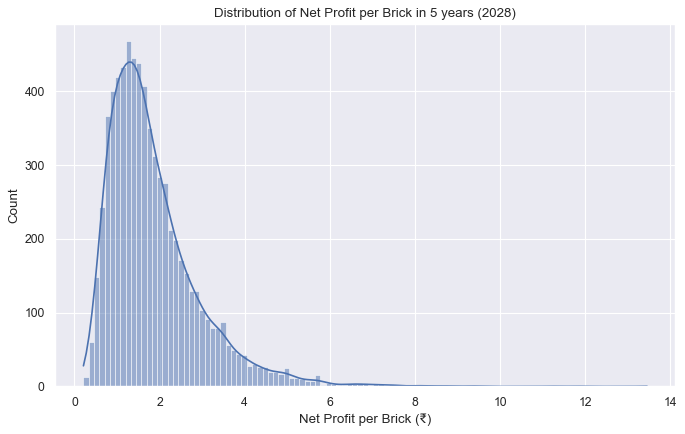

In [158]:
import seaborn as sns

plt.figure(figsize=(10, 6), dpi=80)
sns.set(style="darkgrid")
sns.histplot(end_profit, kde=True)
plt.title("Distribution of Net Profit per Brick in 5 years (2028)")
plt.xlabel("Net Profit per Brick (₹)")
plt.show()

In [159]:
from statistics import median
prob1 = (sum(x > initial for x in end_profit)/len(end_profit))*100
prob2 = (sum(x > 0 for x in end_profit)/len(end_profit))*100
median = median(end_profit)

In [160]:
print("Probability of profit: " + str(prob2) + "%")
print("Probability of higher level of profit per brick in 5 years: " + str(prob1) + "%")
print("Most likely profit per brick in 5 years: $" + str(median))

Probability of profit: 100.0%
Probability of higher level of profit per brick in 5 years: 46.27142857142857%
Most likely profit per brick in 5 years: $1.5919213575058004
